In [1]:
import pickle
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import itertools
from pathlib import Path

import pandas as pd
import weave
from IPython.display import display, Markdown
from tqdm import tqdm

from ydnpd.generation.agent.specifications import *
from ydnpd.generation.agent.utils import produce_datasets
from ydnpd.generation.config import LLM_PATHS
from ydnpd.datasets import load_dataset, mix_datasets, mix_datasets, plot_distribution_distances, plot_dataset_selection, compare_datasets
from ydnpd.utils import metadata_to_pandera_schema
from ydnpd.harness import ALL_EXPERIMENTS

weave.init("ydnpd-data_gen_agent")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


weave version 0.51.29 is available!  To upgrade, please run:
 $ pip install weave --upgrade
Logged in as Weights & Biases user: shlomihod.
View Weave data at https://wandb.ai/shlomihod/ydnpd-data_gen_agent/weave


In [2]:
additional_dataset_path = Path("./llm_datasets")

with open(additional_dataset_path / "results" / "generation-agent.pkl", "rb") as f:
    results = pickle.load(f)

len(results)

90

In [3]:
NUM_DATASETS = 10
PRIVATE_DATASETS = ["acs/national", "edad/2023", "we/2023"]
print(LLM_PATHS)

['openai/gpt-4o-2024-08-06', 'anthropic/claude-3-5-sonnet-20241022', 'together/meta-llama/Llama-3.3-70B-Instruct-Turbo']


In [4]:
# def process_one(dataset_name, llm_path):
        
#     llm_kwargs = {"llm_path": llm_path, "verbose": False}
    
#     produced_datasets, *_ = produce_datasets(
#         dataset_name,
#         SPECIFICATION_V1,
#         NUM_DATASETS,
#         **llm_kwargs)
    
#     return [
#         {
#             "family": dataset_name.split("/")[0],
#             "llm_path": llm_path,
#             "dataset": dataset} 
#         for dataset in produced_datasets
#         ]

# with ThreadPoolExecutor() as executor:
#     # results = []
#     for batch_result in executor.map(process_one, *zip(*itertools.product(PRIVATE_DATASETS, LLM_PATHS))):
#         results.extend(batch_result)

In [5]:
# len(results)

In [6]:
# additional_dataset_path = Path("./llm_datasets")

# with open(additional_dataset_path / "results" / "generation-agent.pkl", "wb") as f:
#     pickle.dump(results, f)

In [7]:
results_df = (pd.DataFrame(results)
              .rename({"family": "dataset_family"}, axis=1)
              .assign(llm_family=lambda r: r["llm_path"].str.split("/").str[-1].str.split("-").str[0].str.lower())
)

pd.crosstab(results_df["llm_family"], results_df["dataset_family"])

dataset_family,acs,edad,we
llm_family,,,
claude,10,10,10
gpt,10,10,10
llama,10,10,10


In [8]:
result_by_family = {}

# Group by dataset_family first
for dataset_family, dataset_group in results_df.groupby('dataset_family'):
    result_by_family[dataset_family] = {llm: dataset_group.loc[idx, 'dataset'].tolist() 
                                        for llm, idx in dataset_group.groupby('llm_family').groups.items()}

# Dataset Family: acs

## LLM: claude

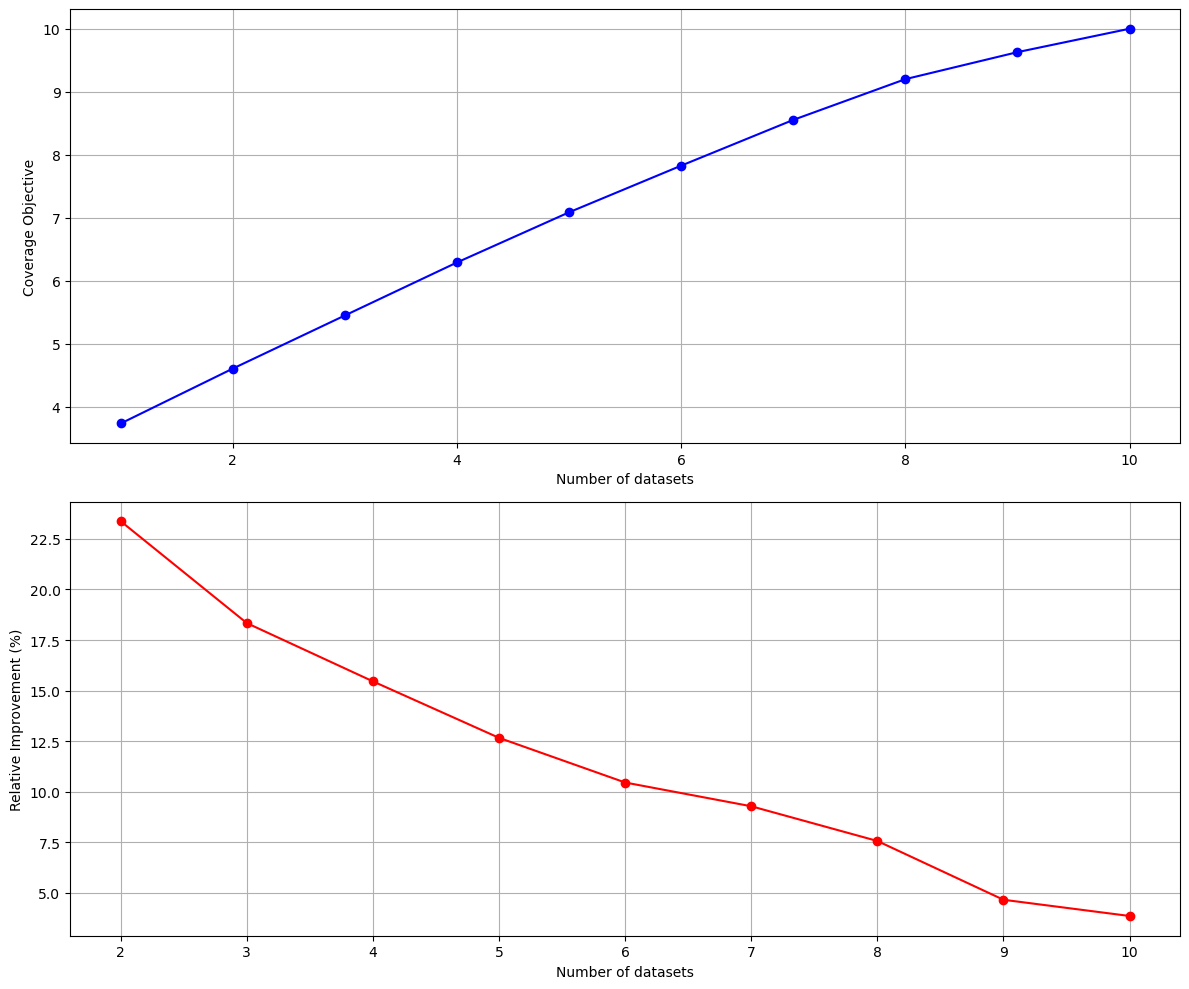

## LLM: gpt

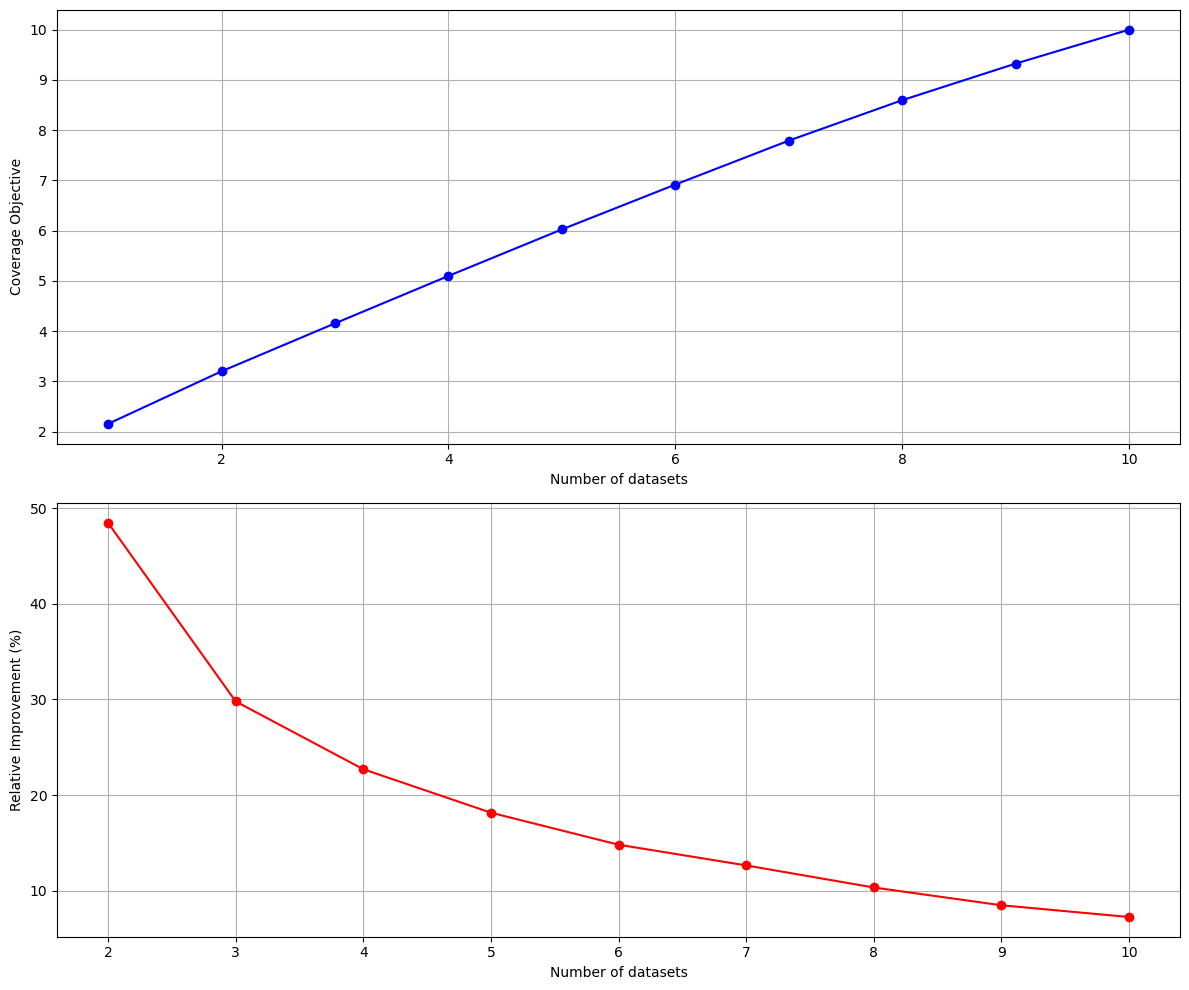

## LLM: llama

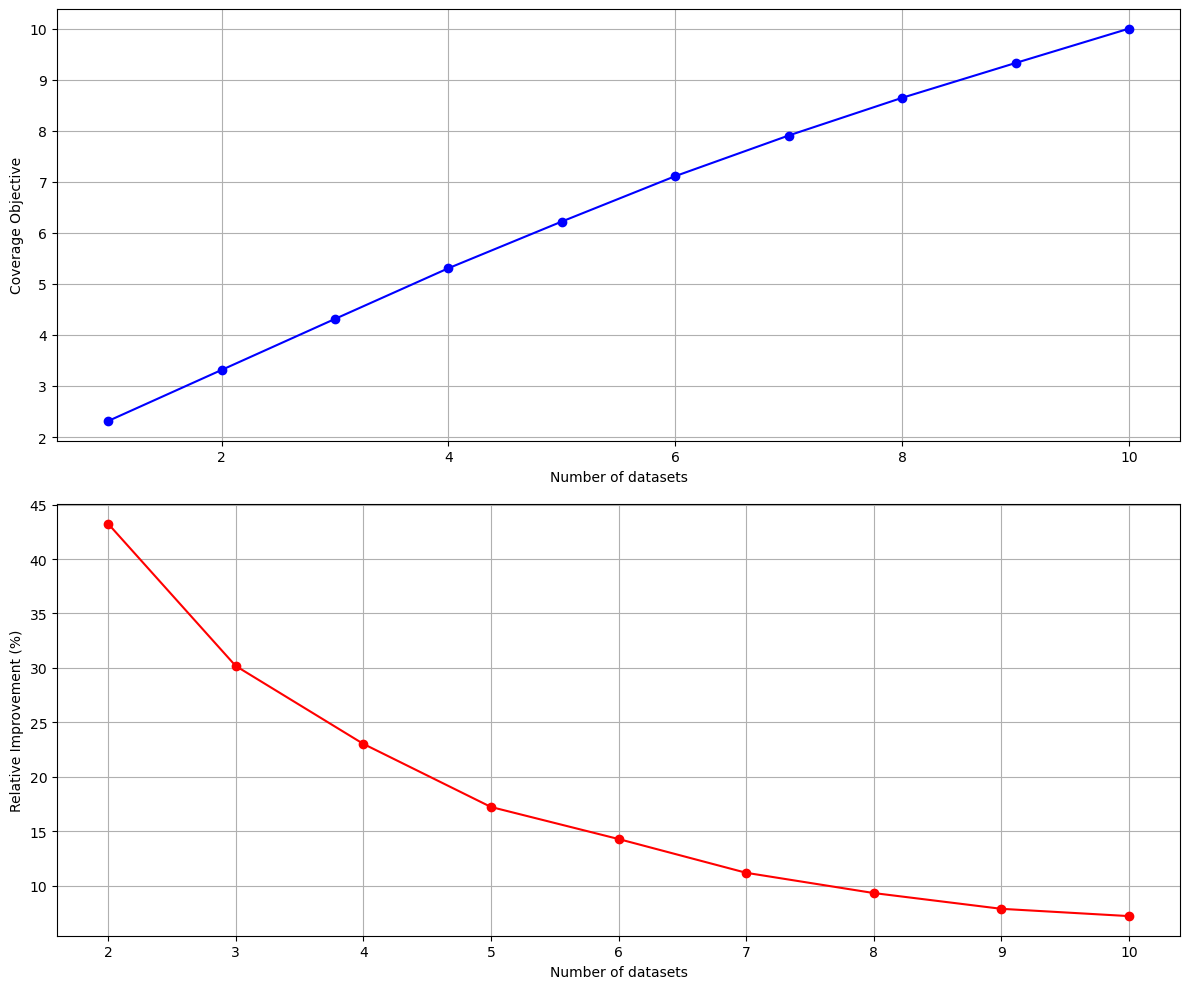

## Overall acs Summary

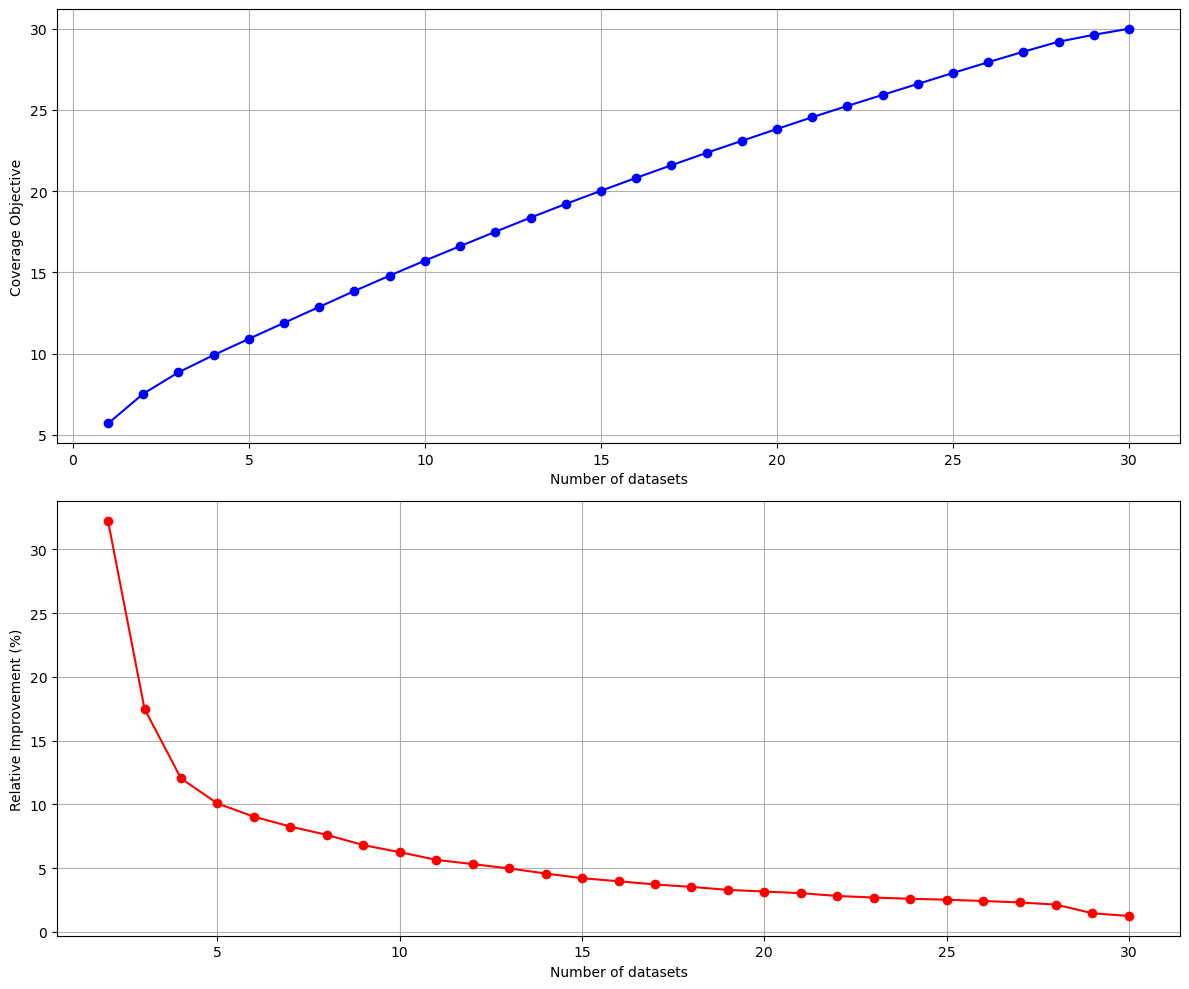

# Dataset Family: edad

## LLM: claude

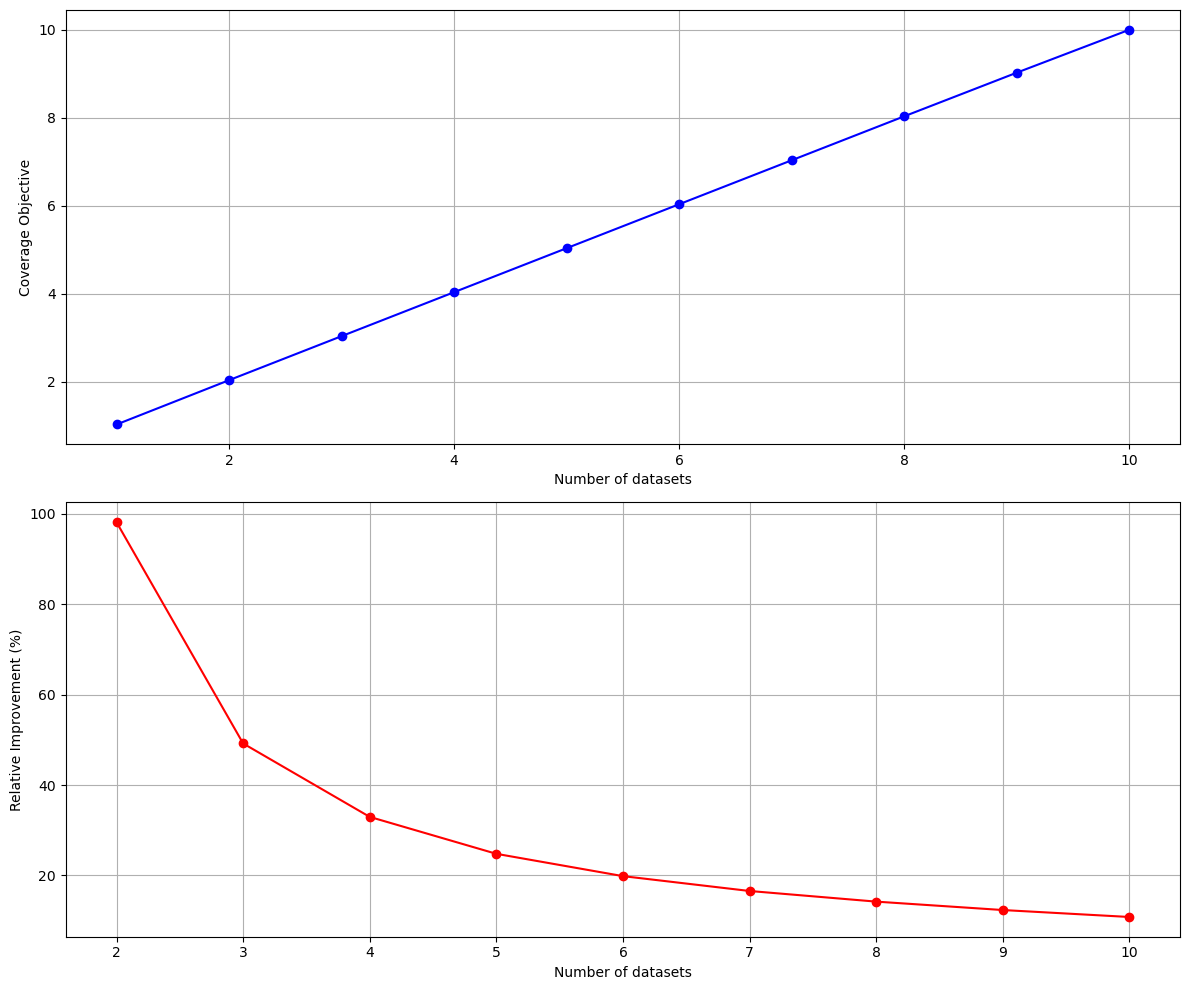

## LLM: gpt

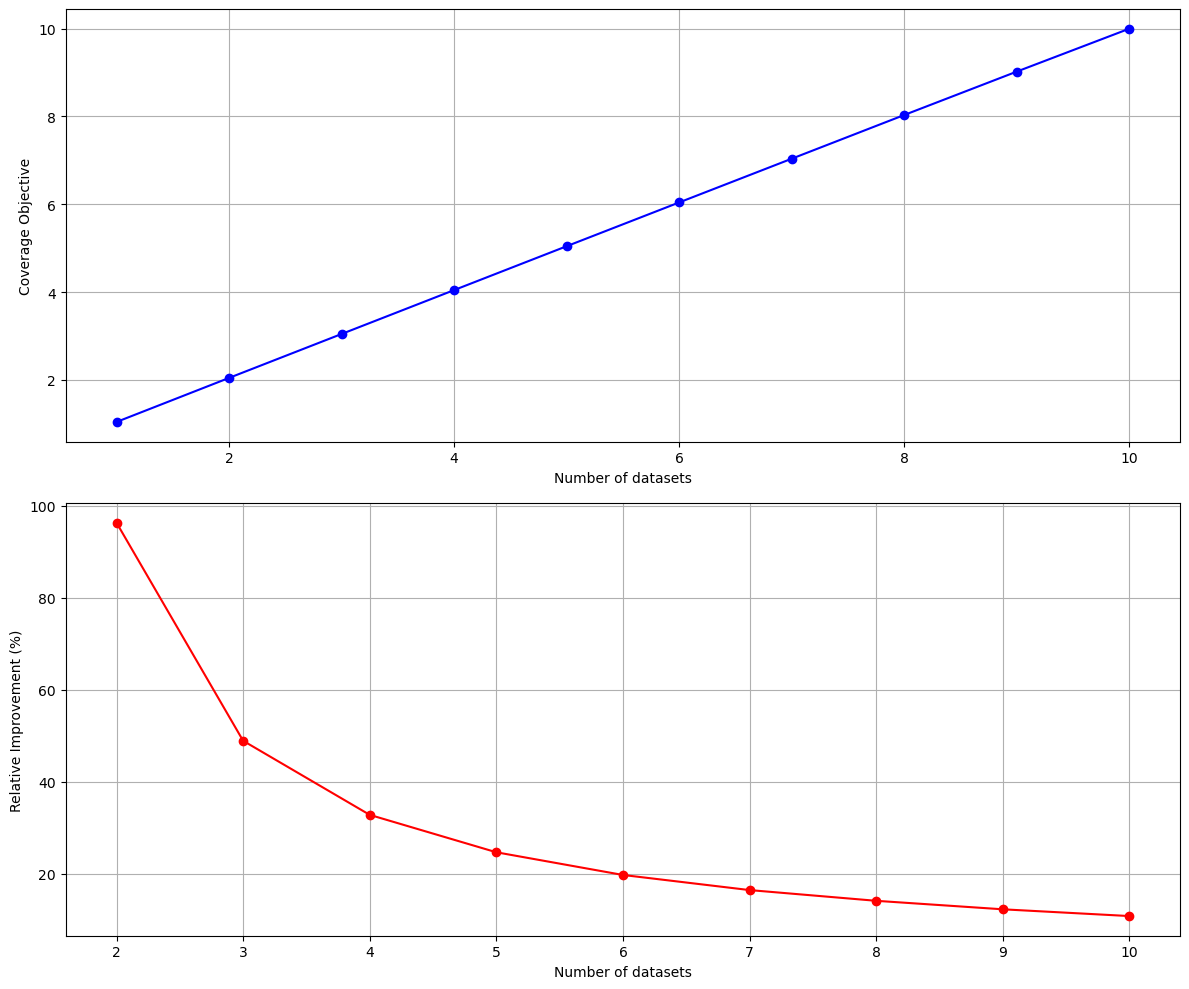

## LLM: llama

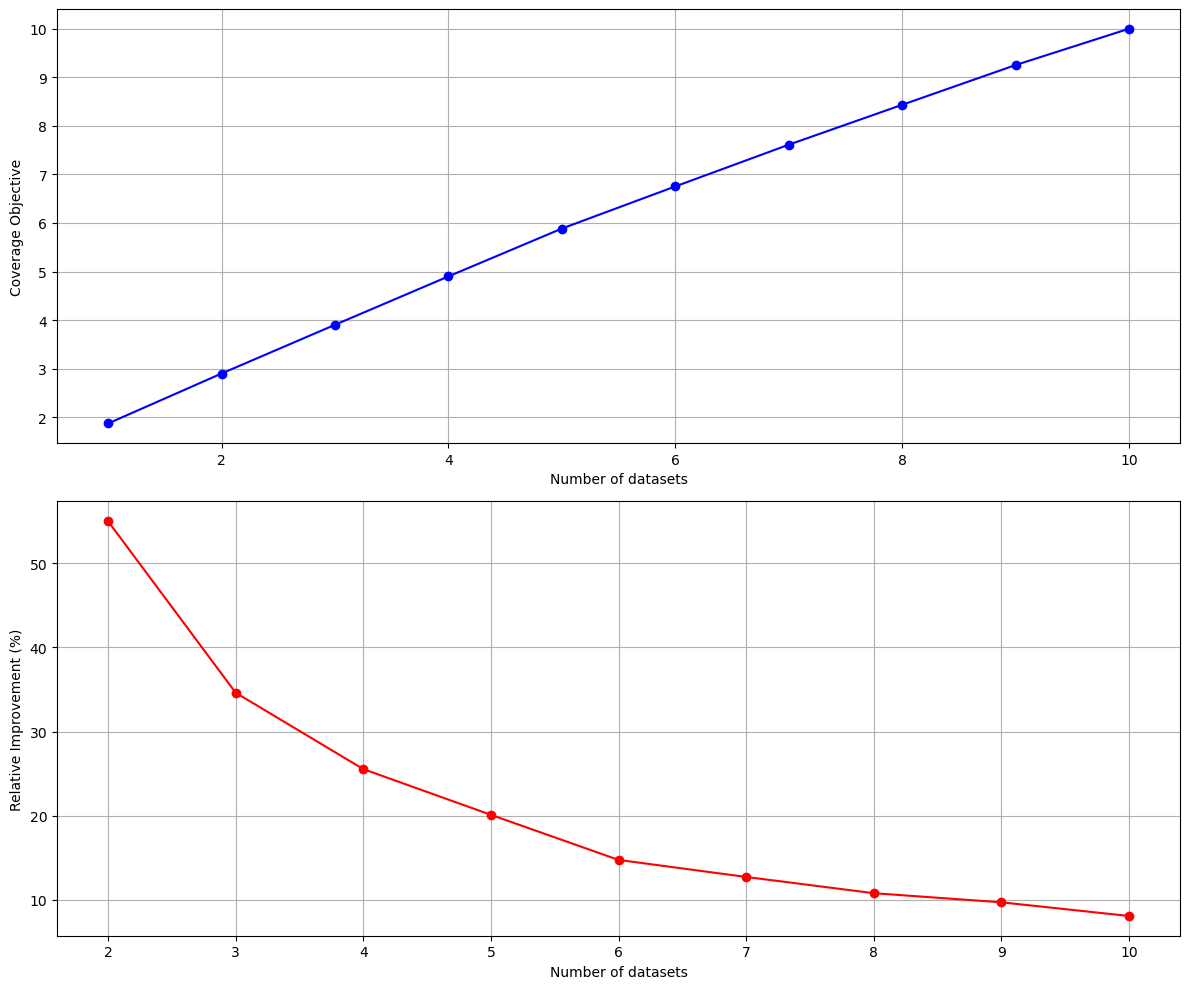

## Overall edad Summary

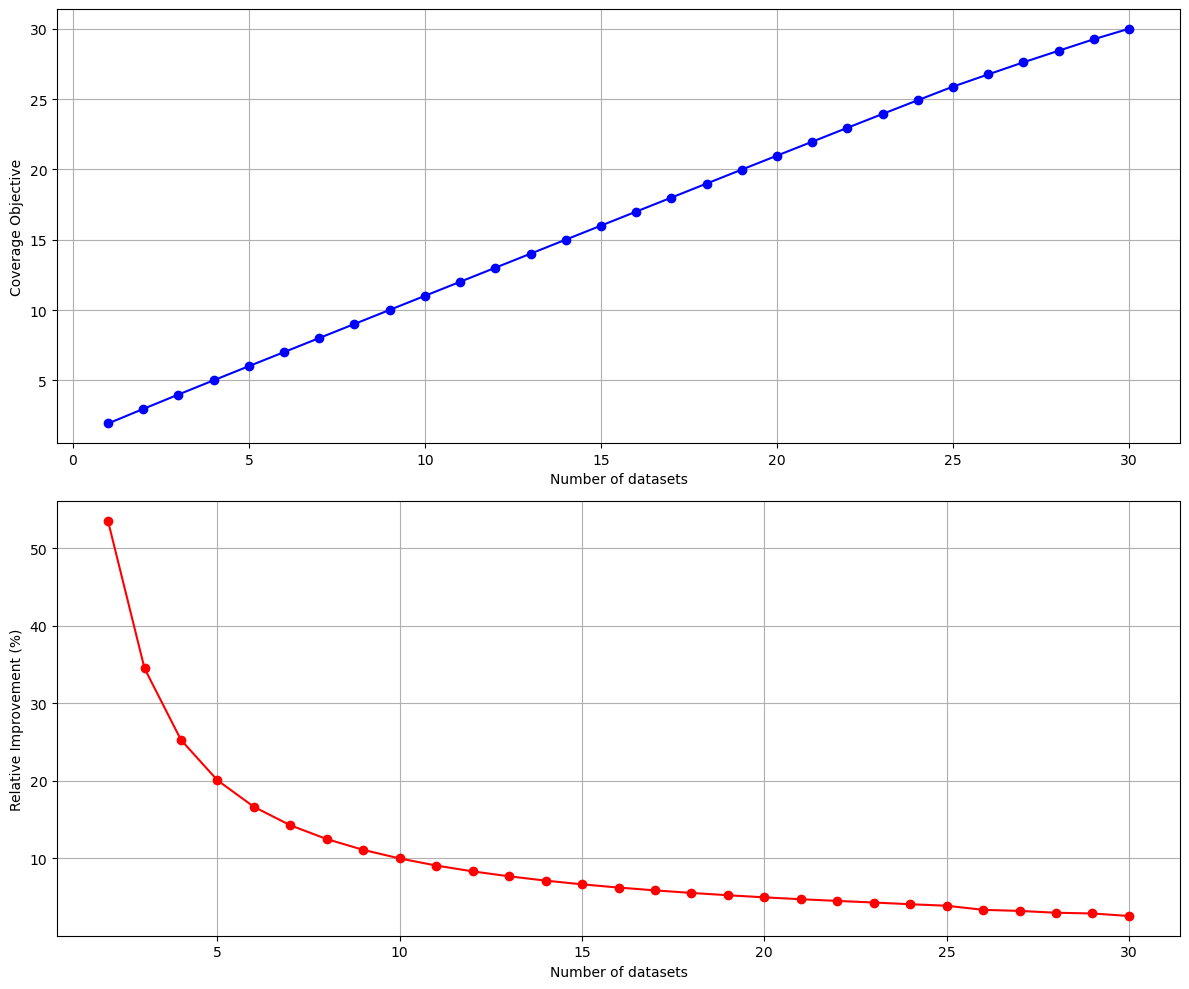

# Dataset Family: we

## LLM: claude

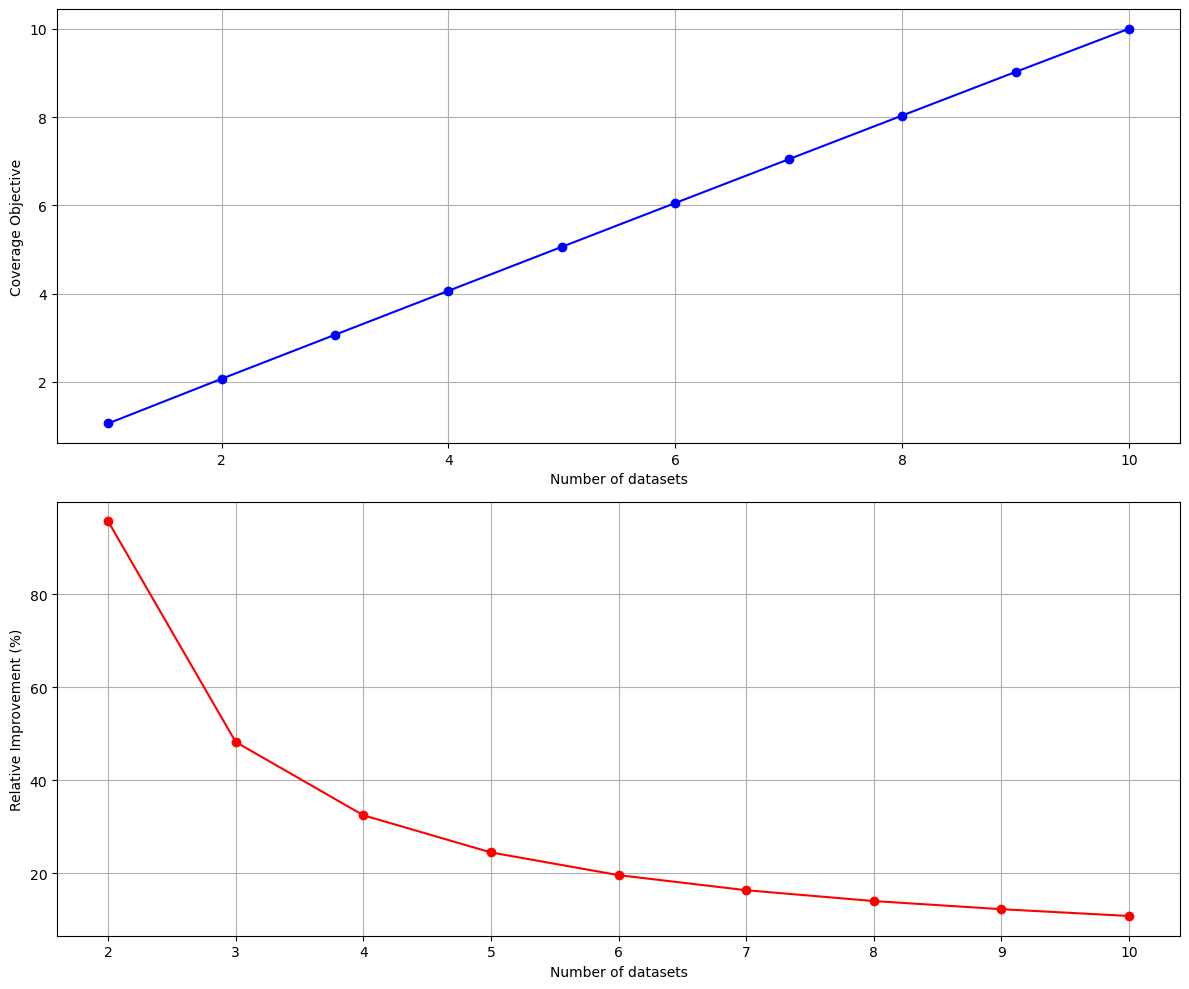

## LLM: gpt

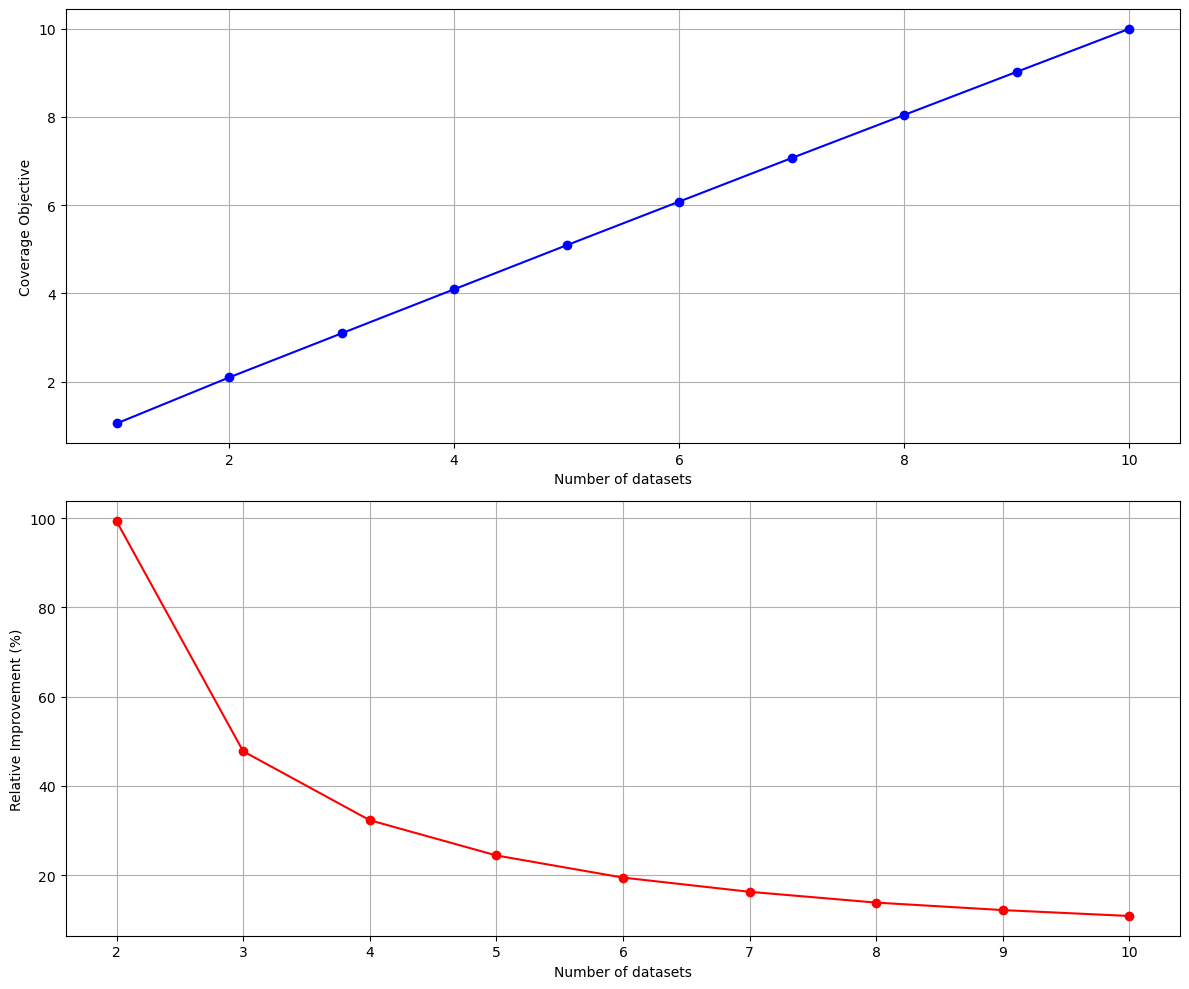

## LLM: llama

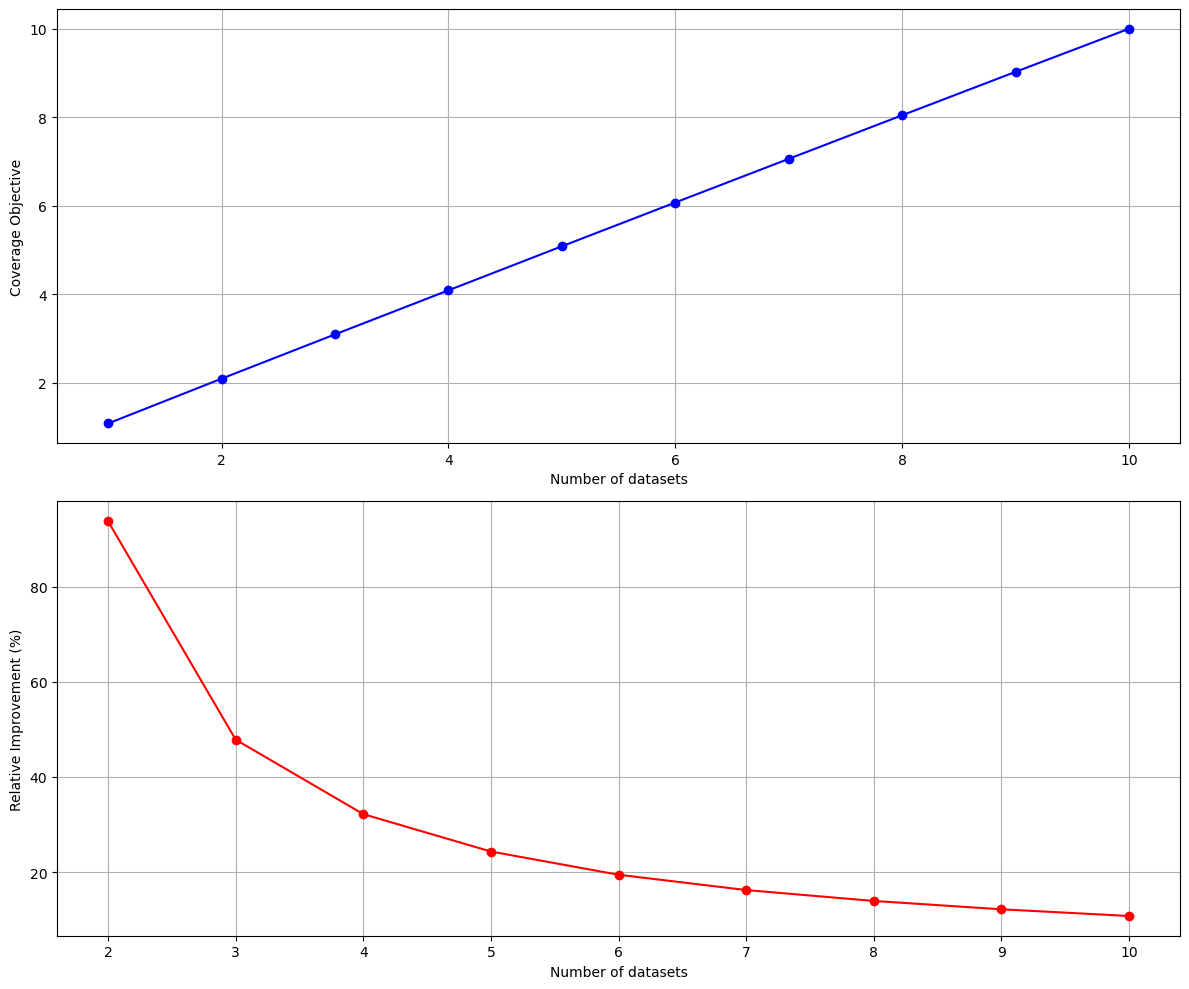

## Overall we Summary

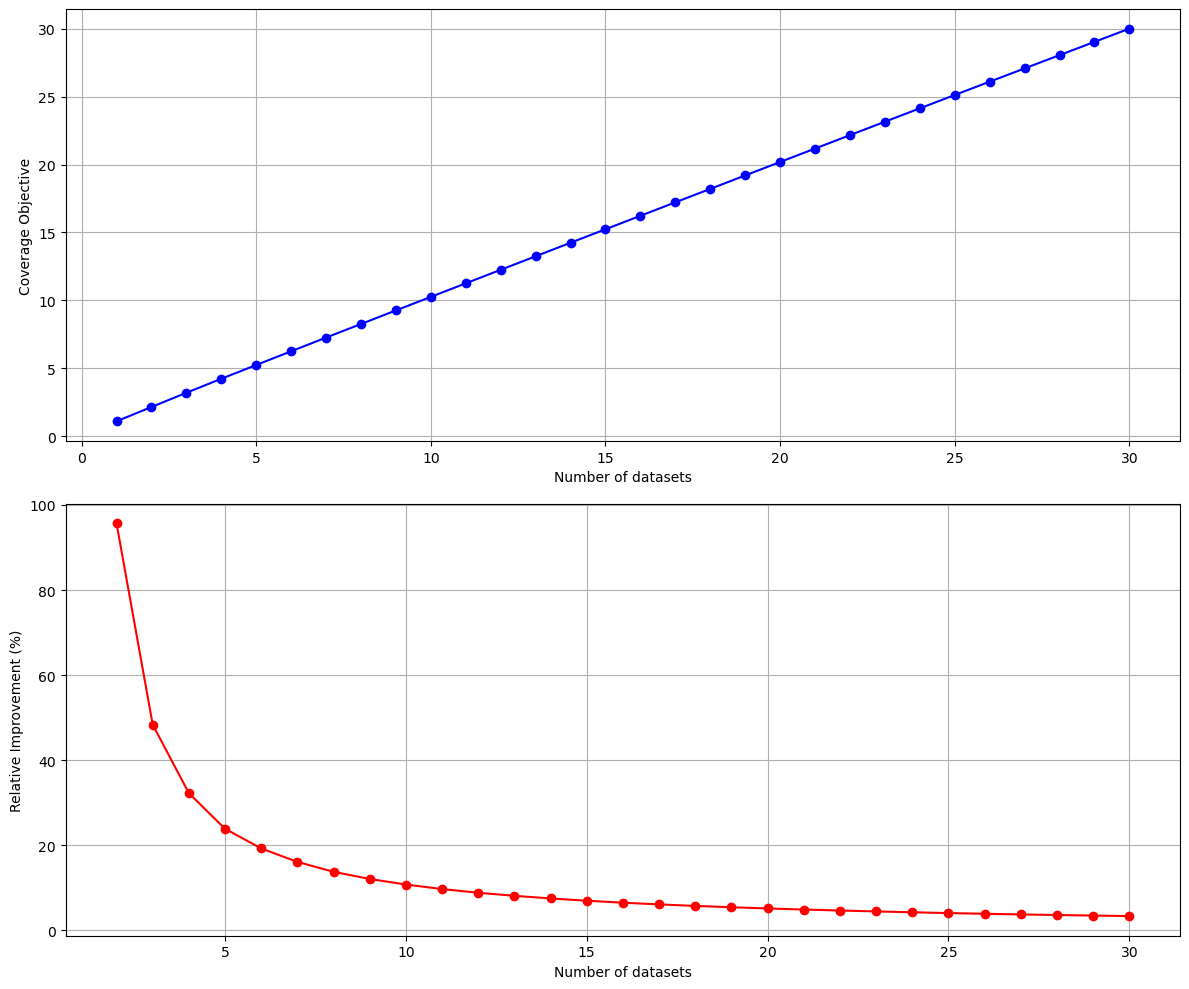

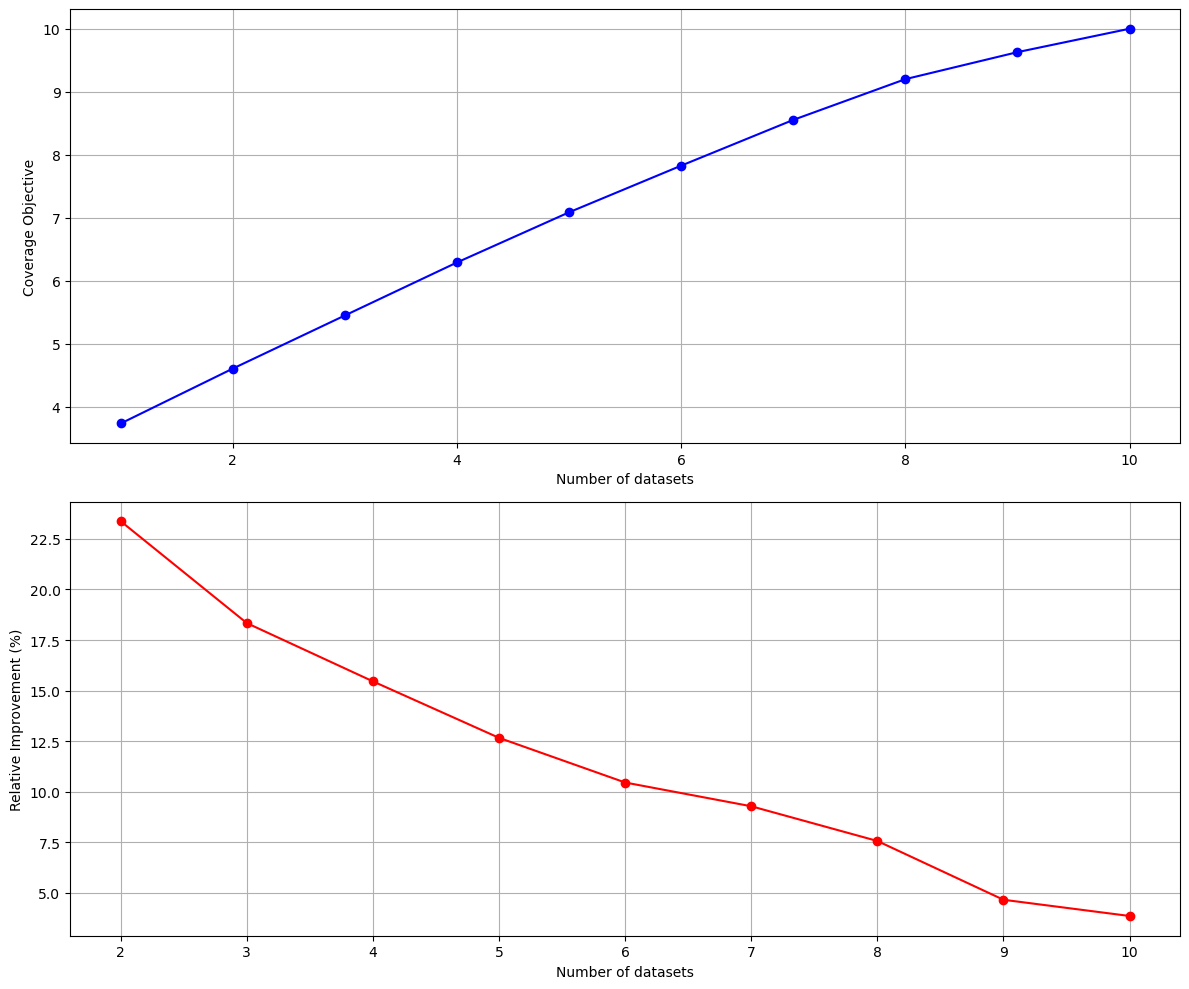

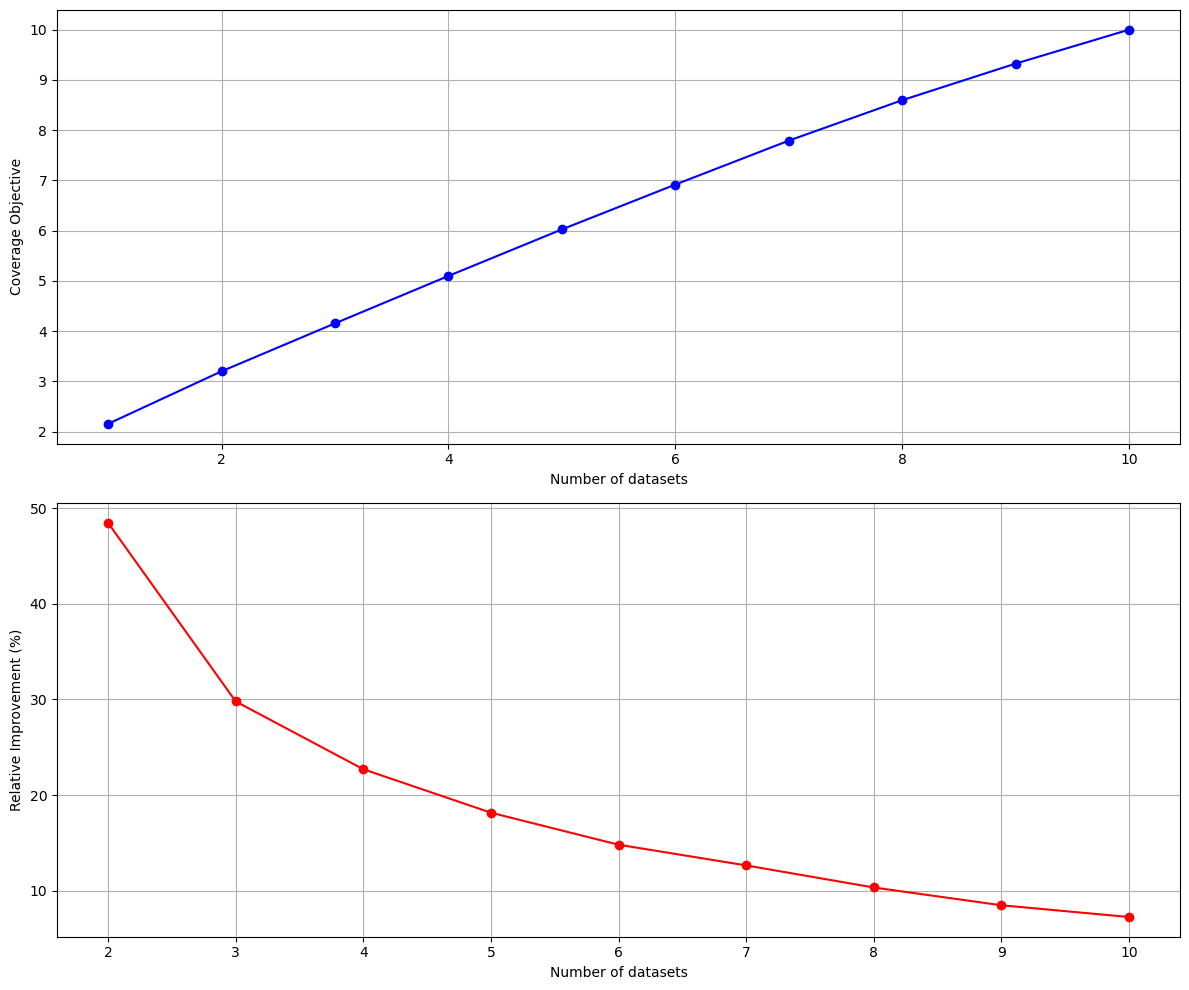

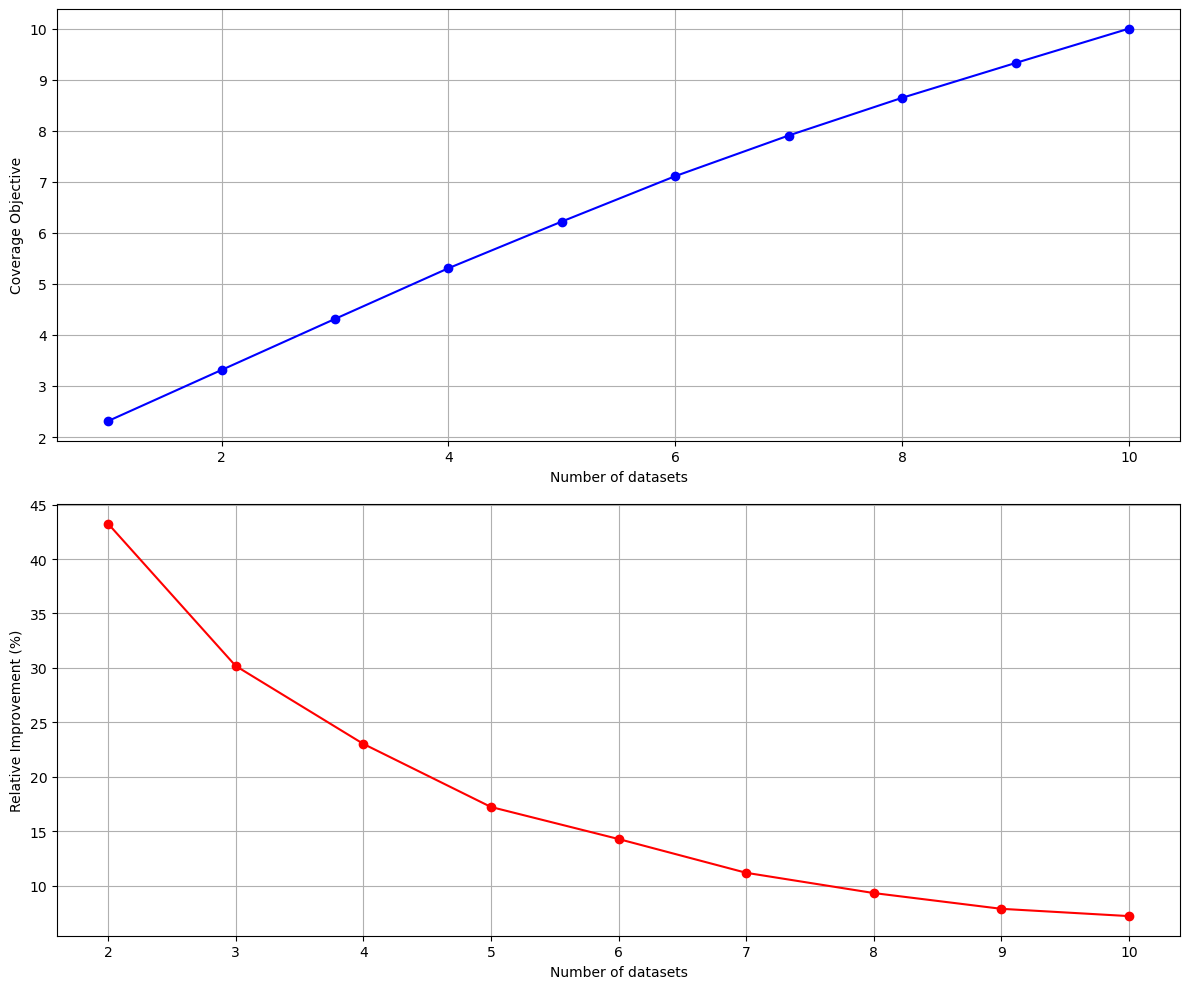

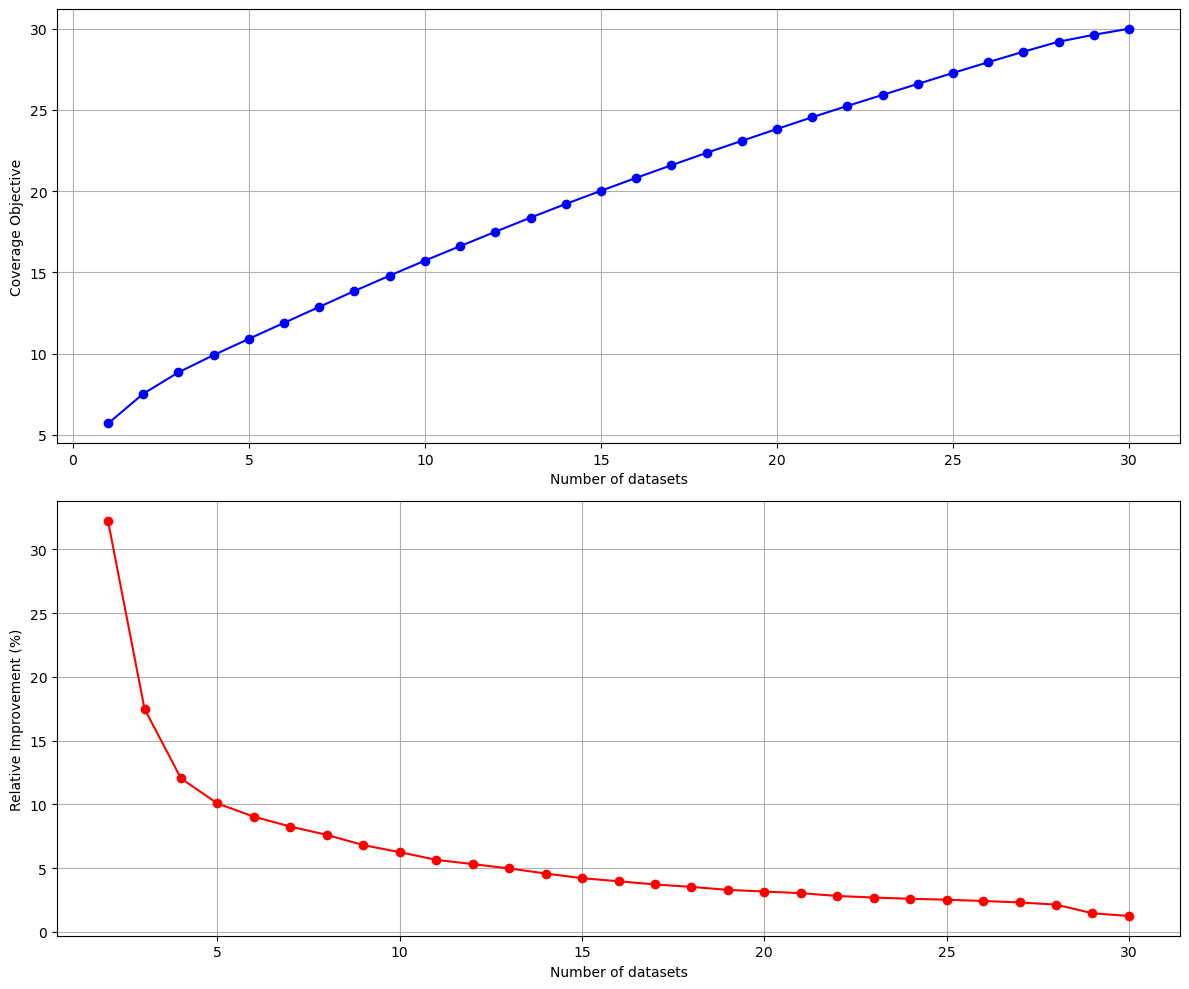

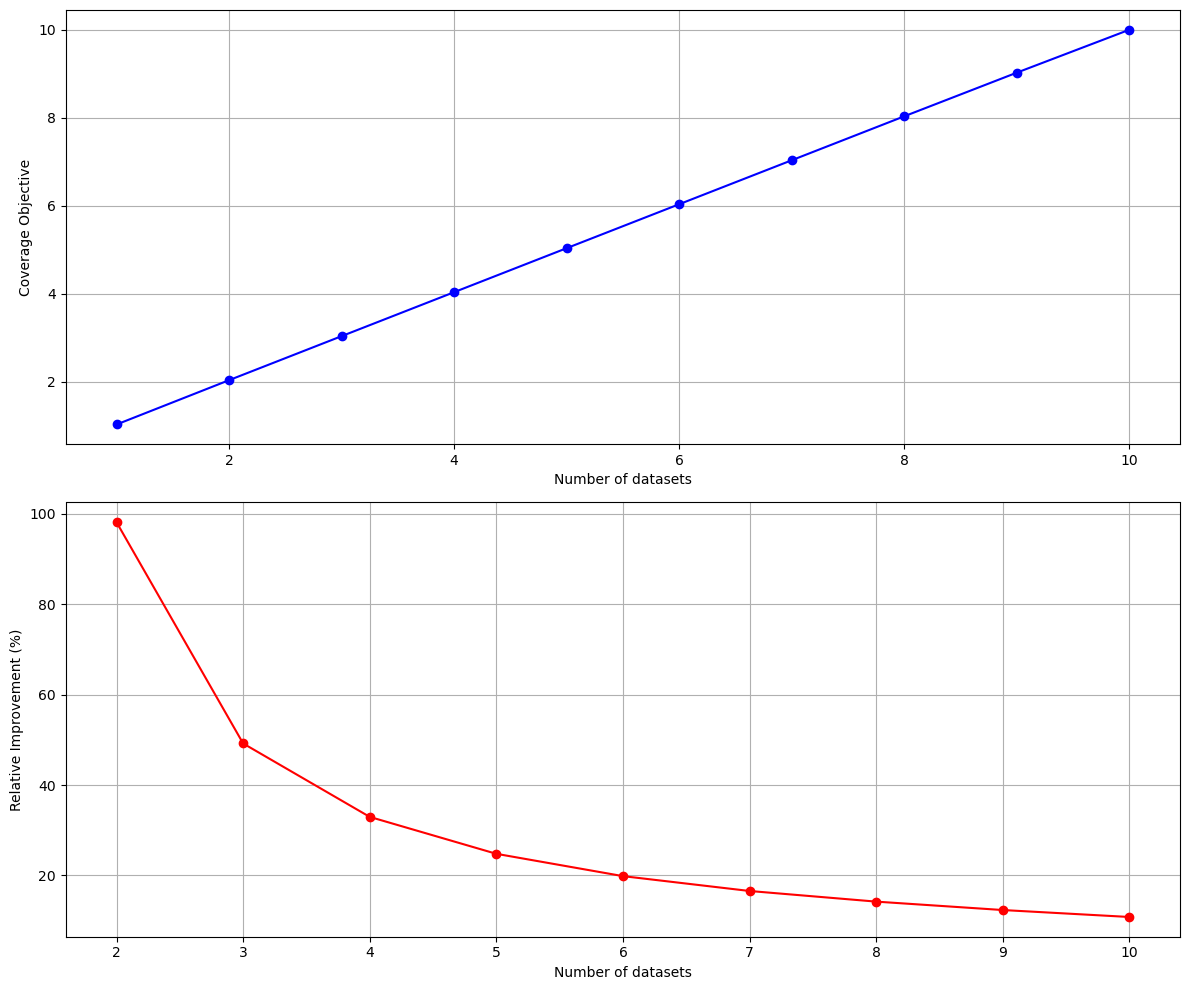

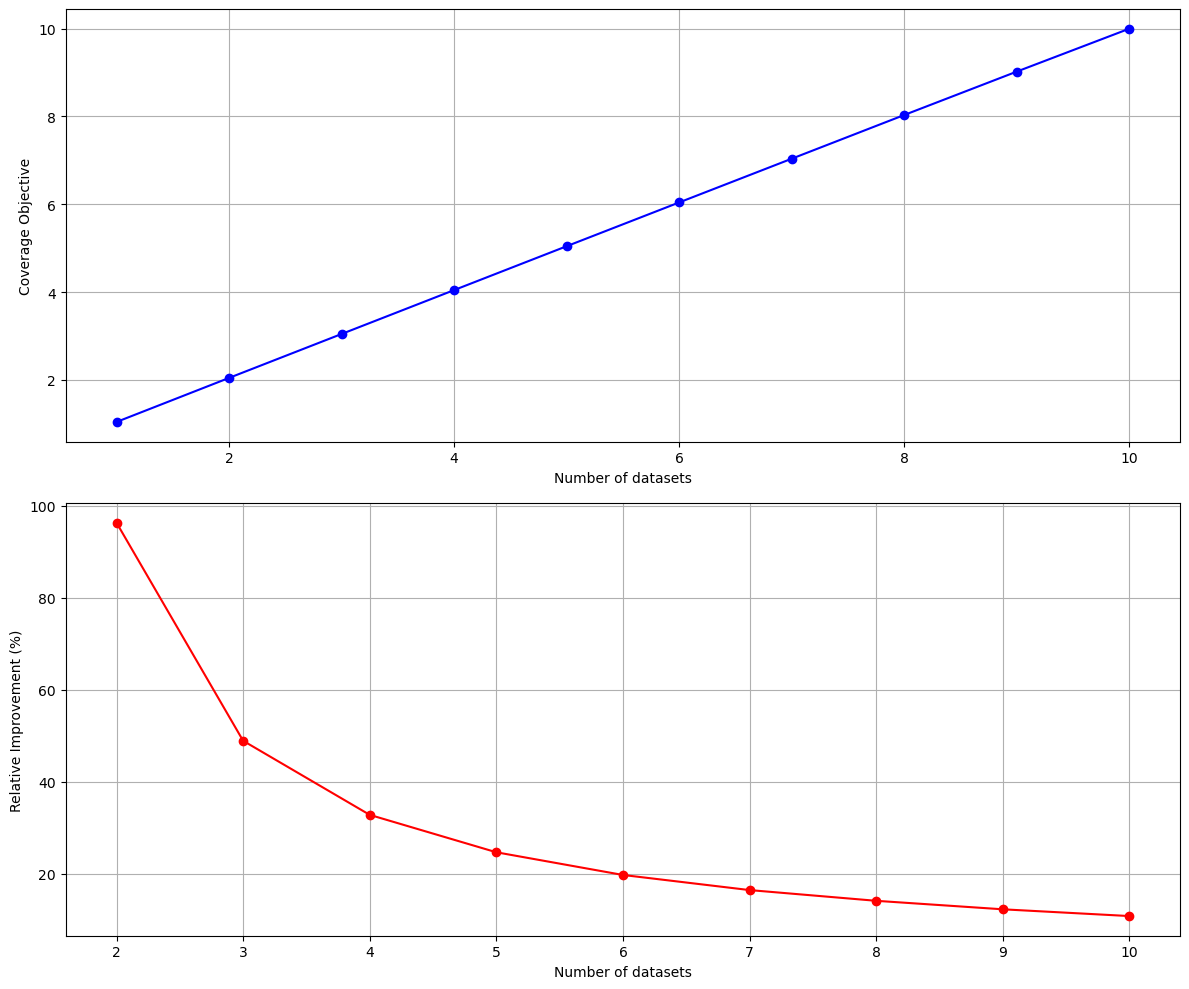

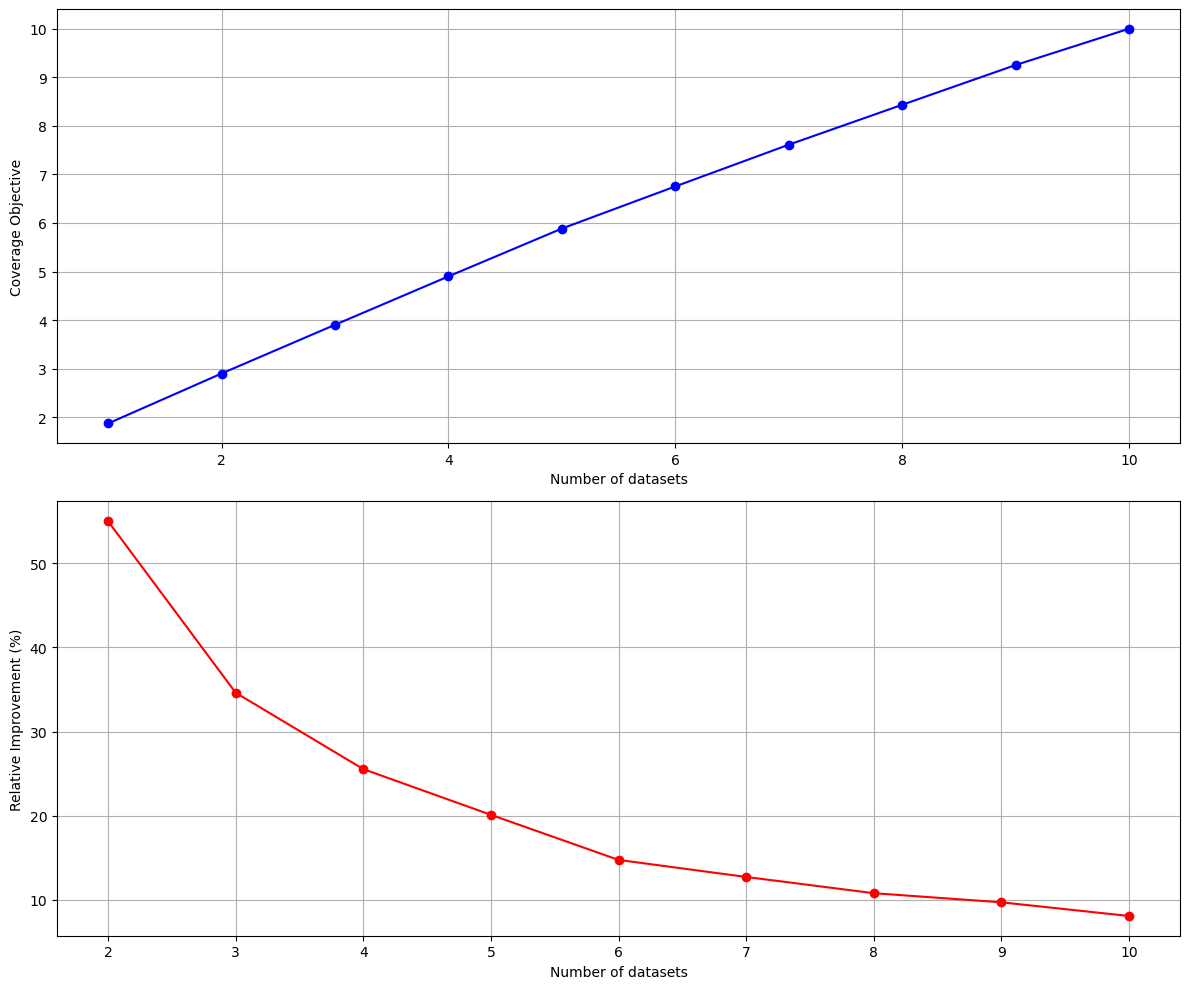

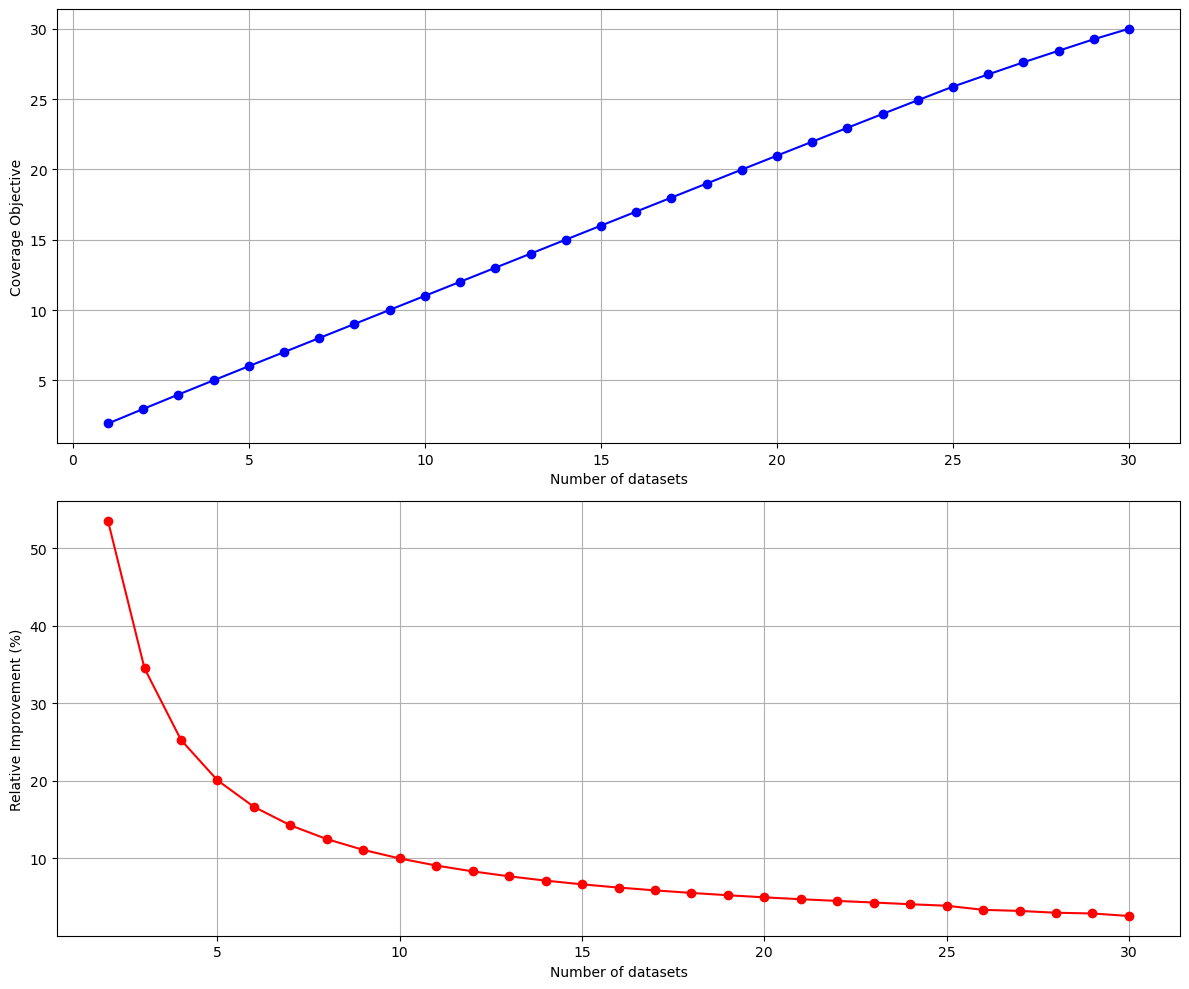

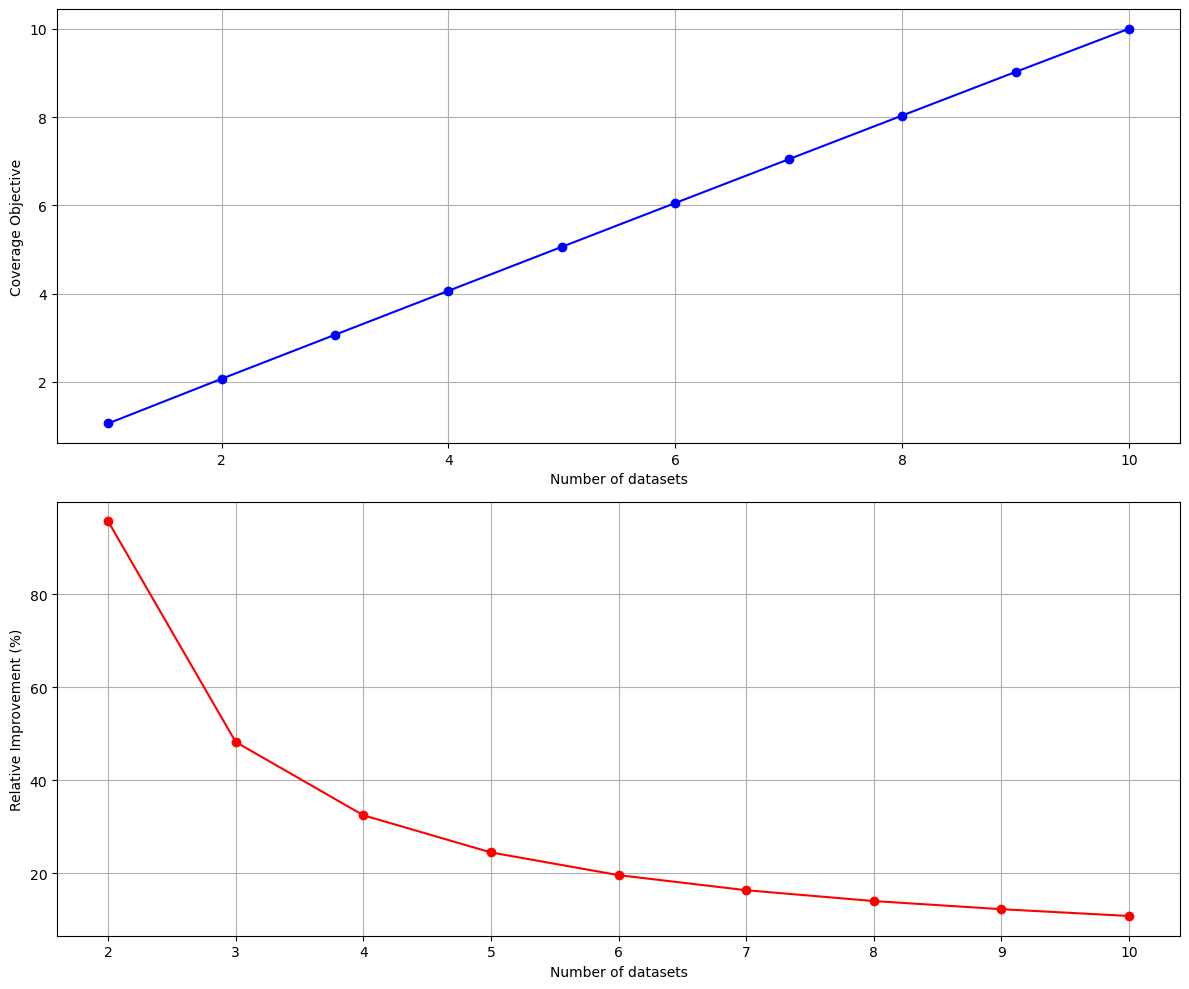

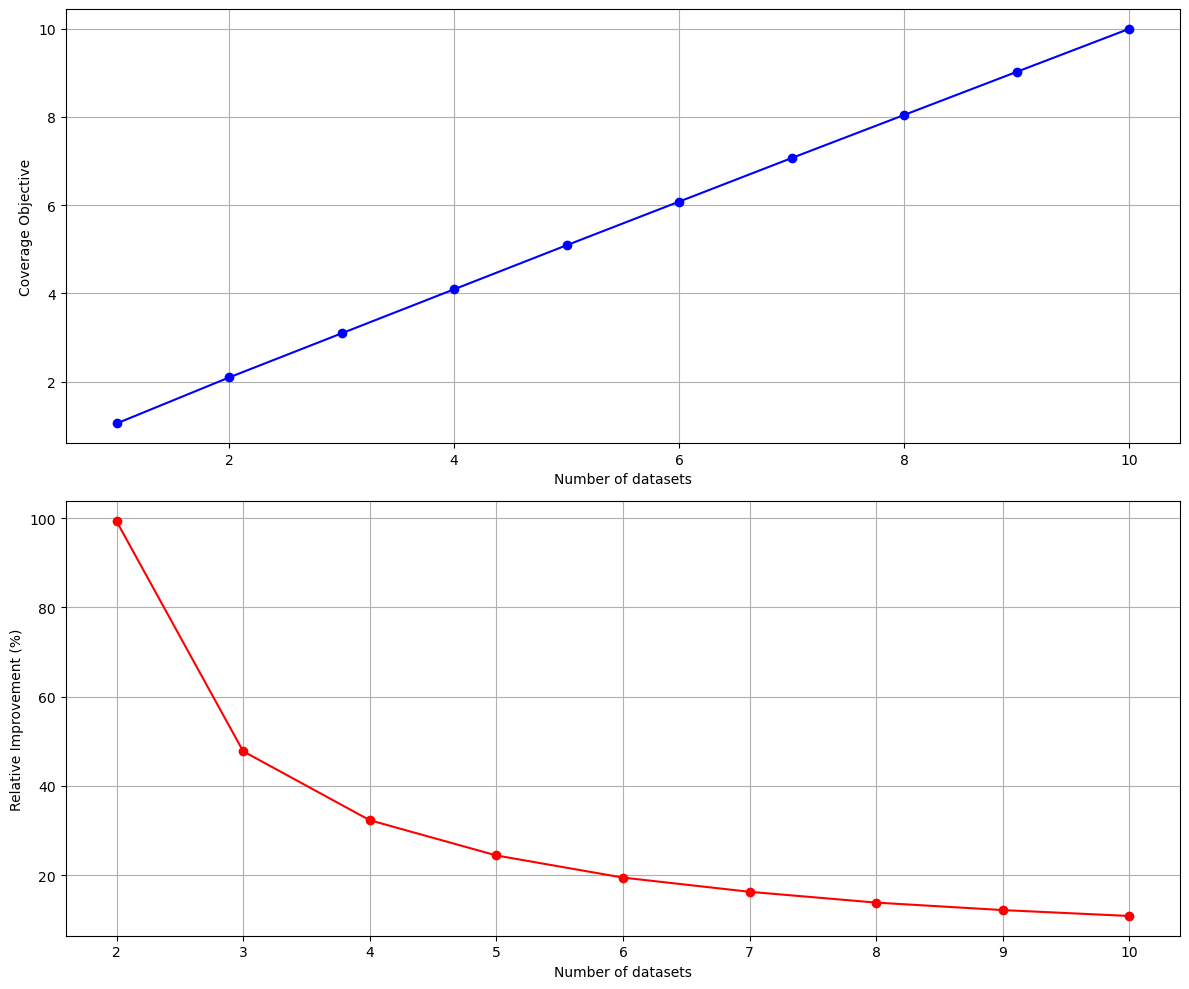

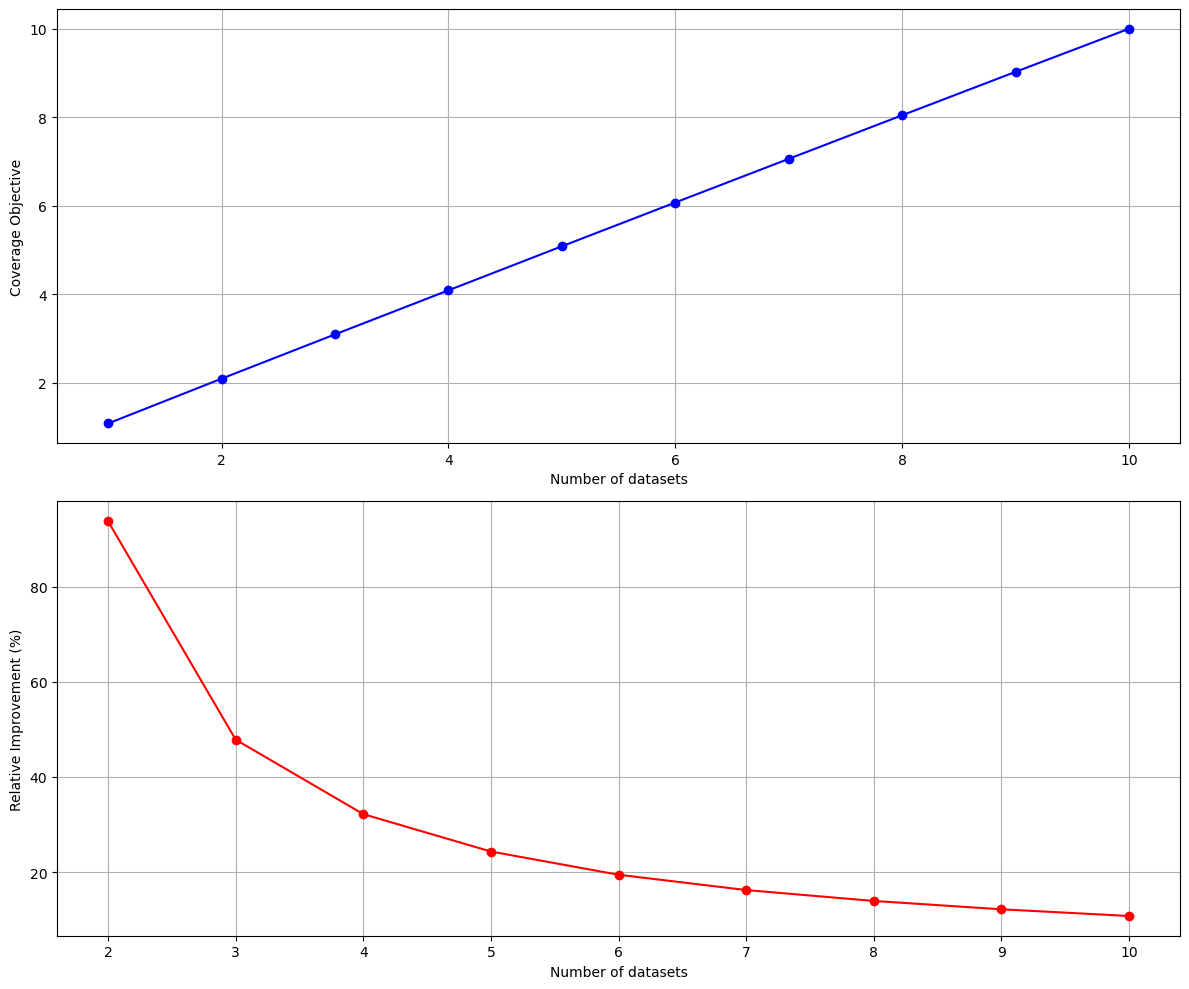

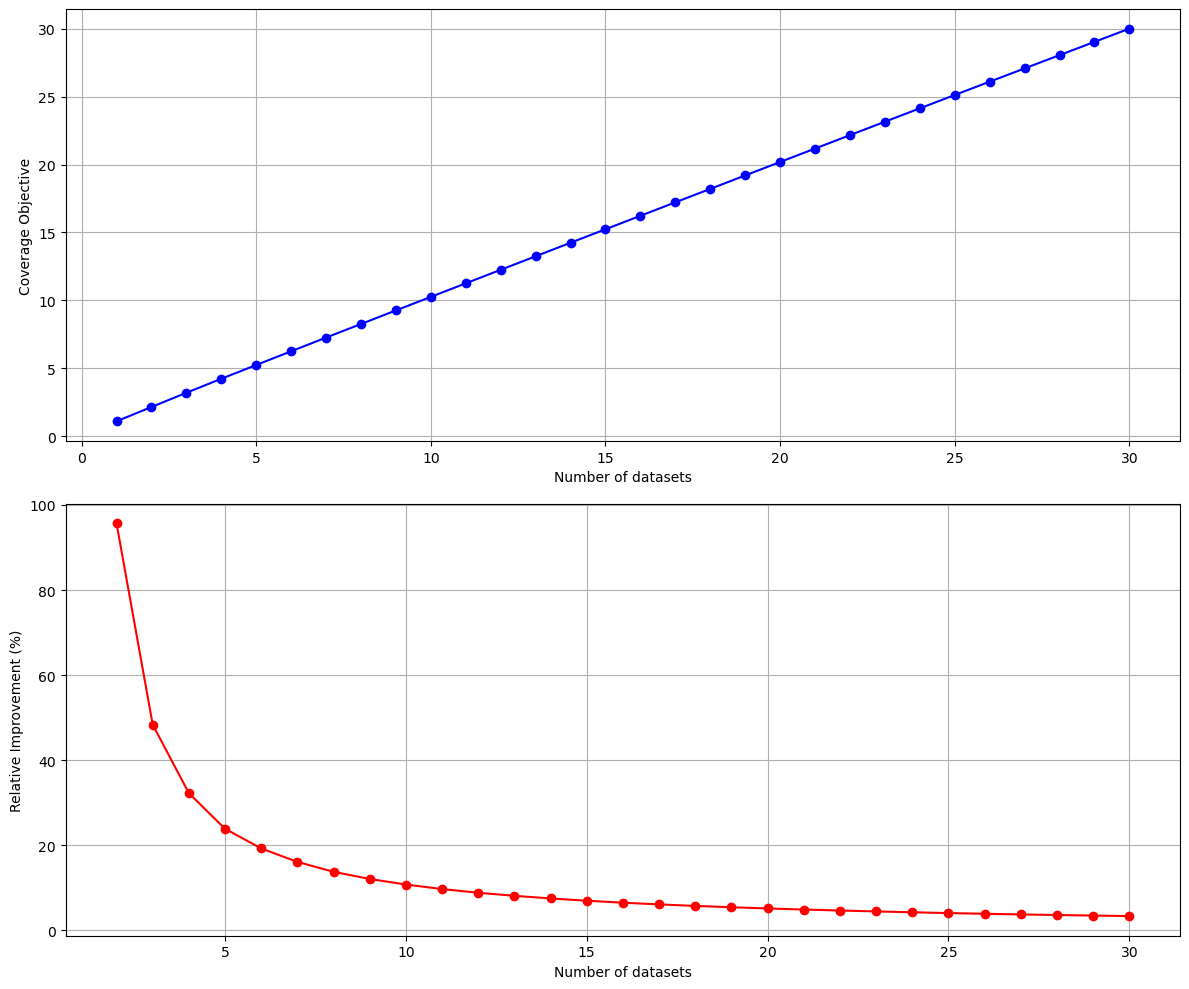

In [9]:
# First create our nested structure as before
result_by_family = {}
for dataset_family, dataset_group in results_df.groupby('dataset_family'):
   result_by_family[dataset_family] = {llm: dataset_group.loc[idx, 'dataset'].tolist() 
                                     for llm, idx in dataset_group.groupby('llm_family').groups.items()}

# Now let's iterate and plot for each combination and summary per family
for dataset_family, llm_groups in result_by_family.items():
   # Dataset family header
   display(Markdown(f"# Dataset Family: {dataset_family}"))
   
   # First show individual LLM plots
   for llm_family, datasets in llm_groups.items():
       display(Markdown(f"## LLM: {llm_family}"))
       
       fig, _ = plot_dataset_selection(datasets)
       display(fig)
   
   # Then show summary for this family
   display(Markdown(f"## Overall {dataset_family} Summary"))
   family_datasets = [dataset for datasets in llm_groups.values() 
                             for dataset in datasets]
   fig, _ = plot_dataset_selection(family_datasets)
   display(fig)

In [10]:
result_by_family.keys()

dict_keys(['acs', 'edad', 'we'])

In [11]:
MIXTURE_MAX_COV_OVERALL_NUM_DATASETS = 10
MIXTURE_MAX_COV_PER_GROUP_NUM_DATASETS = 5

mixture_datasets = {}

# Create mixtures for each dataset family
for dataset_family, llm_groups in tqdm(result_by_family.items()):
    mixture_datasets[dataset_family] = {}  # Initialize nested dict for this family
    
    # Get all datasets for this family
    family_datasets = [dataset for datasets in llm_groups.values() 
                              for dataset in datasets]
    
    # Get number of samples and verify consistency within family
    family_lengths = [len(dataset) for dataset in family_datasets]
    assert len(set(family_lengths)) == 1, f"Inconsistent dataset lengths in {dataset_family}: {family_lengths}"
    num_samples = family_lengths[0]
    
    # Create family-level mixtures
    mixture_datasets[dataset_family]["MIX-UNIF"] = mix_datasets(family_datasets, num_samples, "uniform")
    mixture_datasets[dataset_family]["MIX-MAX"] = mix_datasets(family_datasets, num_samples, "max_coverage", 
                                                             MIXTURE_MAX_COV_OVERALL_NUM_DATASETS)
    
    # Create mixtures for each LLM within this family
    for llm_family, datasets in llm_groups.items():
        mixture_datasets[dataset_family][f"{llm_family}-MIX-UNIF"] = mix_datasets(datasets, num_samples, "uniform")
        mixture_datasets[dataset_family][f"{llm_family}-MIX-MAX"] = mix_datasets(datasets, num_samples, "max_coverage", 
                                                                               MIXTURE_MAX_COV_PER_GROUP_NUM_DATASETS)

100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


In [12]:
mixture_datasets["acs"].keys()

dict_keys(['MIX-UNIF', 'MIX-MAX', 'claude-MIX-UNIF', 'claude-MIX-MAX', 'gpt-MIX-UNIF', 'gpt-MIX-MAX', 'llama-MIX-UNIF', 'llama-MIX-MAX'])

# Distribution Distances for acs

# Distribution Distances for edad

# Distribution Distances for we

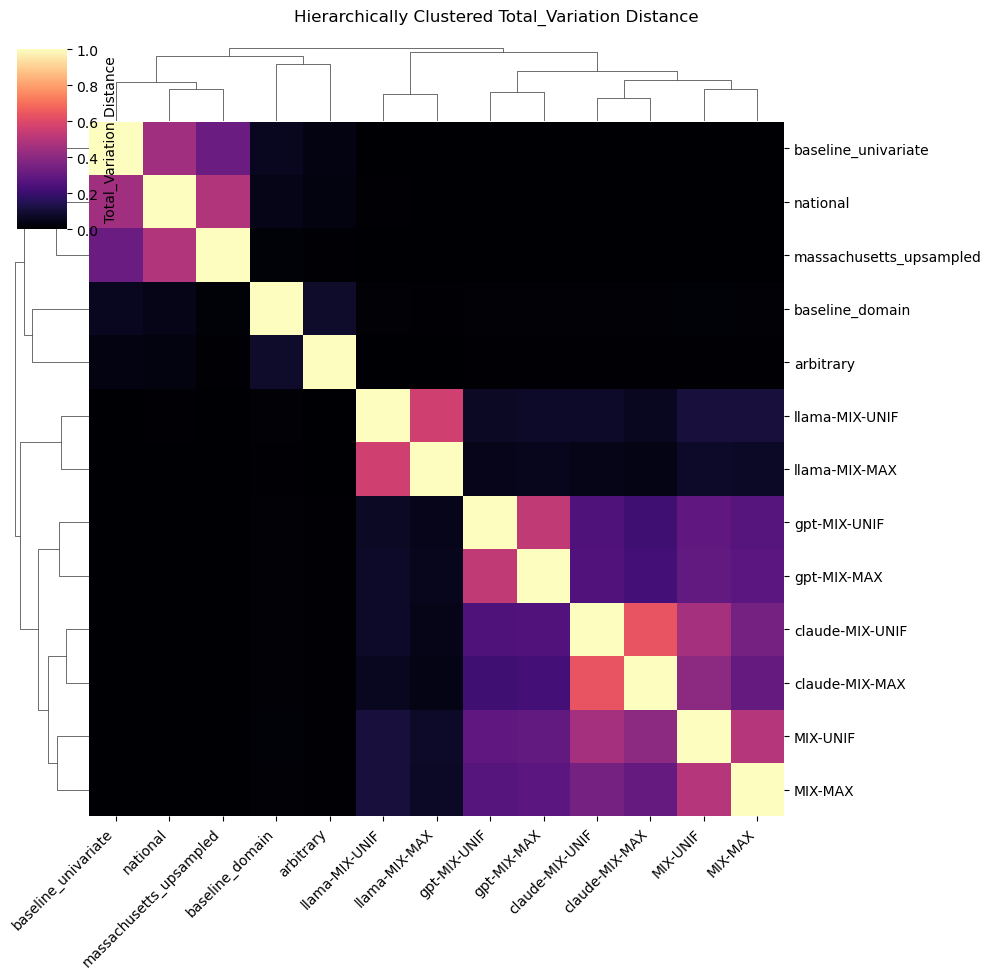

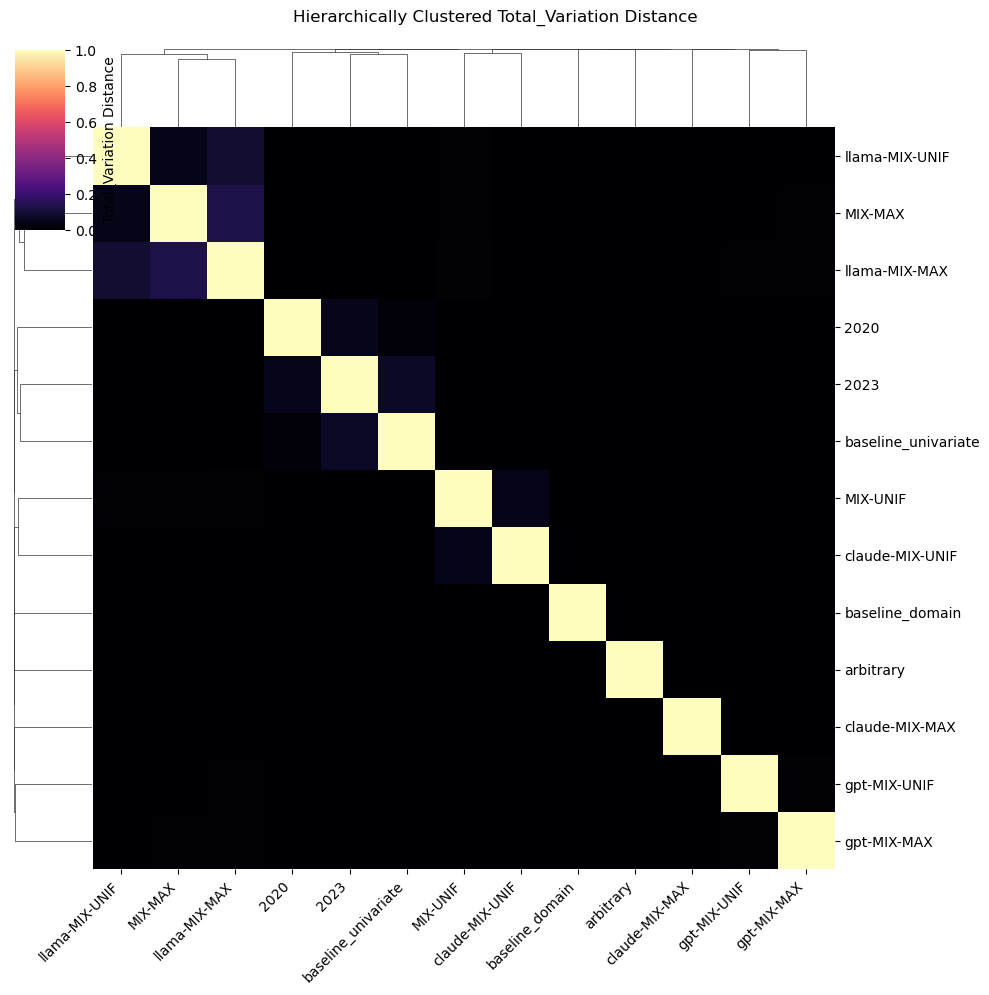

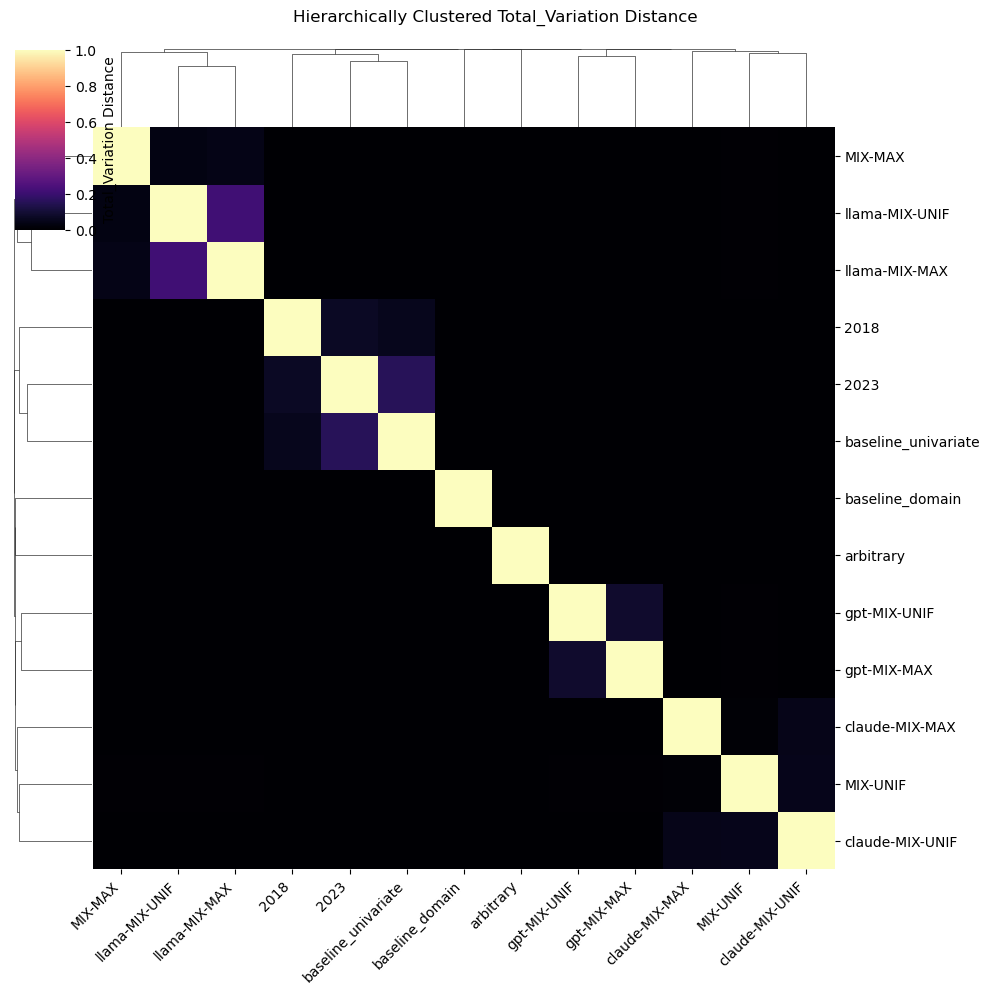

In [13]:
for dataset_family in result_by_family:
    # Create datasets dict for this family
    datasets = {
        name.split("/")[1]: load_dataset(name)[0]
        for name in ALL_EXPERIMENTS[dataset_family].dev_names
    } | mixture_datasets[dataset_family]  # Using the mixtures specific to this family
    
    display(Markdown(f"# Distribution Distances for {dataset_family}"))
    plot_distribution_distances(datasets)

In [14]:
additional_dataset_path = Path("./llm_datasets")

# Iterate through each dataset family and its mixtures
for dataset_family in mixture_datasets:
   # Create family directory if it doesn't exist
   family_dir = additional_dataset_path / dataset_family.lower()
   
   # Save each mixture dataset for this family
   for mix_name, mix_data in mixture_datasets[dataset_family].items():
       filename = f"gen-{mix_name}.csv"
       output_path = family_dir / filename
       
       # Convert to dataframe and save
       mix_data.to_csv(output_path, index=False)